##  Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split
from sklearn.model_selection import TimeSeriesSplit,KFold, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb

import catboost as cb
from time import time

In [ ]:
'''
import glob

path = r'/content/drive/My Drive/Omdena Nigeria Challenge/DataSets/NASA_Weather_Solar_Dataset' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

train = pd.concat(li, axis=0, ignore_index=True)
'''

## Loading dataset

#### Data File available at https://drive.google.com/drive/folders/1Abvor2SMB4ByBdVnfFqYkVJXf7kzQI4i

In [5]:
train = pd.read_csv('Pakistan_complete.csv',low_memory=False)

In [6]:
train.head()

,LAT,LON,YEAR,MO,DY,PRECTOT,RH2M,PS,T2M_RANGE,T2M_MAX,T2M_MIN,T2M,WS10M_RANGE,KT,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,TS,QV2M,ALLSKY_SFC_SW_DWN
0,30.37531,69.34511,2019,1,1,0.0,46.69,87.26,12.48,17.56,5.08,10.18,6.25,0.59,-999.00,6.77,9.94,4.15,3.20
1,30.37531,69.34511,2019,1,2,0.0,37.53,87.37,17.71,18.99,1.28,8.63,4.77,0.70,3.89,5.74,8.55,3.00,3.86
2,30.37531,69.34511,2019,1,3,0.0,30.13,87.48,16.21,18.95,2.74,9.82,3.06,0.63,3.73,6.82,9.59,2.60,3.49
3,30.37531,69.34511,2019,1,4,0.0,41.52,87.18,10.85,16.80,5.95,9.91,6.63,0.63,3.72,6.76,9.31,3.63,3.47
4,30.37531,69.34511,2019,1,5,0.0,35.99,87.13,13.99,15.07,1.09,7.47,5.40,0.66,3.90,5.76,6.97,2.66,3.68


### Parameter Definitions

PRECTOT = Precipitation Per Day mm <br>
PS = Surface Pressure <br>
TS = Earth Skin Temperature<br>
QV2M = Specific Humidity<br>
RH2M = Relative Humidity<br>
KT = Insolation Clearness Index<br>
ALLSKY_SFC_SW_DWN	 = All Sky Insolation Incident on a Horizontal Surface<br>
CLRSKY_SFC_SW_DWN = Clear Sky Insolation Incident On a Horizontal Surface 


## Data Preprocessing

In [7]:
drop_column = ['T2M_RANGE','T2M_MAX','T2M_MIN','WS10M_RANGE','KT',
               'CLRSKY_SFC_SW_DWN','ALLSKY_SFC_LW_DWN','TS','QV2M',
               'PRECTOT']


In [8]:
def preprocess(data, drop_column):
    data = data[data.ALLSKY_SFC_SW_DWN!= -999]
    data = data.drop(columns = drop_column)
    return data

In [9]:
train_processed = preprocess(train,drop_column)

In [10]:
y = train_processed.ALLSKY_SFC_SW_DWN.values
train_processed = train_processed.drop(columns = ['ALLSKY_SFC_SW_DWN'])

In [11]:
train_processed.head()

,LAT,LON,YEAR,MO,DY,RH2M,PS,T2M
0,30.37531,69.34511,2019,1,1,46.69,87.26,10.18
1,30.37531,69.34511,2019,1,2,37.53,87.37,8.63
2,30.37531,69.34511,2019,1,3,30.13,87.48,9.82
3,30.37531,69.34511,2019,1,4,41.52,87.18,9.91
4,30.37531,69.34511,2019,1,5,35.99,87.13,7.47


## Building the KFold XGBoost Model

In [ ]:
'''
clf = lgb.LGBMRegressor(
    
                         n_estimators = 1000,
                         objective ='regression',
       

                        )
time_now = time()
clf.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds=100,  
                    eval_set=[(X_train, y_train), (X_test, y_test)],verbose=True)
time_new = time()
training_duration = time_new - time_now
print(f"Total Training time: {training_duration:.3f} seconds")
'''

In [ ]:
'''

X_train, X_test, y_train, y_test = train_test_split(train_processed, y, 
                                                    test_size = 0.2,random_state = 1)

clf = xgb.XGBRegressor(
                            
                        n_estimators=100,
                        min_child_weight = 2,
                        max_depth=6,
                        verbosity = 1,
                        n_jobs=8,                                              
                        scale_pos_weight=1.025,
                        tree_method='exact',
                        objective = 'reg:squarederror',
                        predictor='cpu_predictor',
                        colsample_bytree = 0.66,
                        subsample = 1,
                        gamma = 0,
                        learning_rate=0.15,
                        num_parallel_tree = 1,    
                       )
    
  
clf.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds=50,
                eval_set=[(X_train, y_train), (X_test, y_test)],verbose=True) 
'''

In [16]:
n_fold = 5
random_state = 999
kf = KFold(n_splits = n_fold , shuffle = True, random_state = random_state)

models = []
train_no = 1
training_cycle = 10000
for train_index, val_index in kf.split(train_processed, y):
    train_X = train_processed.iloc[train_index]
    val_X = train_processed.iloc[val_index]
    train_y = y[train_index]
    val_y = y[val_index]
    
    
    clf = xgb.XGBRegressor(
                            
                        n_estimators= training_cycle,
                        min_child_weight = 2,
                        max_depth=6,
                        verbosity = 1,
                        n_jobs=8,                                              
                        scale_pos_weight=1.025,
                        #tree_method='gpu_exact',
                        objective = 'reg:squarederror',
                        #predictor='gpu_predictor',
                        colsample_bytree = 0.66,
                        subsample = 1,
                        gamma = 0,
                        learning_rate=0.15,
                        num_parallel_tree = 1,    
                       )
    

    clf.fit(train_X, train_y, eval_metric="rmse", early_stopping_rounds=50,
                eval_set=[(train_X, train_y), (val_X, val_y)],verbose=True)
    
    models.append(clf)

[0]	validation_0-rmse:4.41080	validation_1-rmse:4.26204
[1]	validation_0-rmse:3.77787	validation_1-rmse:3.64557
[2]	validation_0-rmse:3.24678	validation_1-rmse:3.14760
[3]	validation_0-rmse:2.78979	validation_1-rmse:2.71023
[4]	validation_0-rmse:2.40479	validation_1-rmse:2.35245
[5]	validation_0-rmse:2.08107	validation_1-rmse:2.05589
[6]	validation_0-rmse:1.80262	validation_1-rmse:1.80441
[7]	validation_0-rmse:1.56726	validation_1-rmse:1.60185
[8]	validation_0-rmse:1.37345	validation_1-rmse:1.43750
[9]	validation_0-rmse:1.20983	validation_1-rmse:1.29655
[10]	validation_0-rmse:1.08011	validation_1-rmse:1.19206
[11]	validation_0-rmse:0.96028	validation_1-rmse:1.10685
[12]	validation_0-rmse:0.86583	validation_1-rmse:1.04866
[13]	validation_0-rmse:0.78360	validation_1-rmse:0.99361
[14]	validation_0-rmse:0.71485	validation_1-rmse:0.94939
[15]	validation_0-rmse:0.66080	validation_1-rmse:0.91566
[16]	validation_0-rmse:0.61438	validation_1-rmse:0.89935
[17]	validation_0-rmse:0.57043	validation

[68]	validation_0-rmse:0.21368	validation_1-rmse:0.79092
[69]	validation_0-rmse:0.20858	validation_1-rmse:0.79153
[70]	validation_0-rmse:0.20561	validation_1-rmse:0.79256
[71]	validation_0-rmse:0.20224	validation_1-rmse:0.79270
[72]	validation_0-rmse:0.20018	validation_1-rmse:0.79305
[73]	validation_0-rmse:0.19766	validation_1-rmse:0.79315
[74]	validation_0-rmse:0.19586	validation_1-rmse:0.79377
[0]	validation_0-rmse:4.37750	validation_1-rmse:4.40684
[1]	validation_0-rmse:3.75002	validation_1-rmse:3.77576
[2]	validation_0-rmse:3.22431	validation_1-rmse:3.25587
[3]	validation_0-rmse:2.76973	validation_1-rmse:2.80266
[4]	validation_0-rmse:2.38856	validation_1-rmse:2.43379
[5]	validation_0-rmse:2.06861	validation_1-rmse:2.12288
[6]	validation_0-rmse:1.79405	validation_1-rmse:1.86028
[7]	validation_0-rmse:1.56380	validation_1-rmse:1.64402
[8]	validation_0-rmse:1.37245	validation_1-rmse:1.47895
[9]	validation_0-rmse:1.21035	validation_1-rmse:1.34769
[10]	validation_0-rmse:1.08250	validation

[50]	validation_0-rmse:0.29913	validation_1-rmse:0.70199
[51]	validation_0-rmse:0.29811	validation_1-rmse:0.70310
[52]	validation_0-rmse:0.29592	validation_1-rmse:0.70301
[53]	validation_0-rmse:0.29434	validation_1-rmse:0.70242
[54]	validation_0-rmse:0.29303	validation_1-rmse:0.70386
[55]	validation_0-rmse:0.28831	validation_1-rmse:0.70641
[56]	validation_0-rmse:0.28697	validation_1-rmse:0.70710
[57]	validation_0-rmse:0.28357	validation_1-rmse:0.70723
[58]	validation_0-rmse:0.27991	validation_1-rmse:0.70706
[59]	validation_0-rmse:0.27710	validation_1-rmse:0.70898
[60]	validation_0-rmse:0.27599	validation_1-rmse:0.70872
[61]	validation_0-rmse:0.27168	validation_1-rmse:0.70873
[62]	validation_0-rmse:0.26734	validation_1-rmse:0.70929
[63]	validation_0-rmse:0.26447	validation_1-rmse:0.70914
[64]	validation_0-rmse:0.25926	validation_1-rmse:0.70758
[65]	validation_0-rmse:0.25628	validation_1-rmse:0.70825
[66]	validation_0-rmse:0.25231	validation_1-rmse:0.70829
[67]	validation_0-rmse:0.25049	

[112]	validation_0-rmse:0.15925	validation_1-rmse:0.68227
[113]	validation_0-rmse:0.15902	validation_1-rmse:0.68215
[114]	validation_0-rmse:0.15842	validation_1-rmse:0.68142
[115]	validation_0-rmse:0.15562	validation_1-rmse:0.68122
[116]	validation_0-rmse:0.15436	validation_1-rmse:0.68154
[117]	validation_0-rmse:0.15338	validation_1-rmse:0.68137
[118]	validation_0-rmse:0.15324	validation_1-rmse:0.68138
[119]	validation_0-rmse:0.15263	validation_1-rmse:0.68143
[120]	validation_0-rmse:0.15166	validation_1-rmse:0.68086
[121]	validation_0-rmse:0.15042	validation_1-rmse:0.68013
[122]	validation_0-rmse:0.14849	validation_1-rmse:0.68072
[123]	validation_0-rmse:0.14814	validation_1-rmse:0.68093
[124]	validation_0-rmse:0.14743	validation_1-rmse:0.68097
[125]	validation_0-rmse:0.14606	validation_1-rmse:0.68055
[126]	validation_0-rmse:0.14472	validation_1-rmse:0.68016
[127]	validation_0-rmse:0.14244	validation_1-rmse:0.68095
[128]	validation_0-rmse:0.14207	validation_1-rmse:0.68104
[129]	validati

[254]	validation_0-rmse:0.05792	validation_1-rmse:0.68002
[255]	validation_0-rmse:0.05786	validation_1-rmse:0.68004
[256]	validation_0-rmse:0.05716	validation_1-rmse:0.68014
[257]	validation_0-rmse:0.05708	validation_1-rmse:0.68010
[258]	validation_0-rmse:0.05598	validation_1-rmse:0.67988
[259]	validation_0-rmse:0.05584	validation_1-rmse:0.67987
[260]	validation_0-rmse:0.05575	validation_1-rmse:0.67991
[261]	validation_0-rmse:0.05569	validation_1-rmse:0.67992
[262]	validation_0-rmse:0.05547	validation_1-rmse:0.67997
[263]	validation_0-rmse:0.05509	validation_1-rmse:0.67992
[264]	validation_0-rmse:0.05489	validation_1-rmse:0.67995
[265]	validation_0-rmse:0.05339	validation_1-rmse:0.68004
[266]	validation_0-rmse:0.05188	validation_1-rmse:0.67959
[267]	validation_0-rmse:0.05166	validation_1-rmse:0.67963
[268]	validation_0-rmse:0.05141	validation_1-rmse:0.67966
[269]	validation_0-rmse:0.05122	validation_1-rmse:0.67985
[270]	validation_0-rmse:0.05030	validation_1-rmse:0.67920
[271]	validati

In [32]:
print(models)

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.66, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=6,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1.025, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.66, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=6,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=0,

In [36]:
len(models[1].evals_result()['validation_1']['rmse'])

76

In [39]:
len(models[1].evals_result()['validation_0']['rmse'])

76

### Training graph

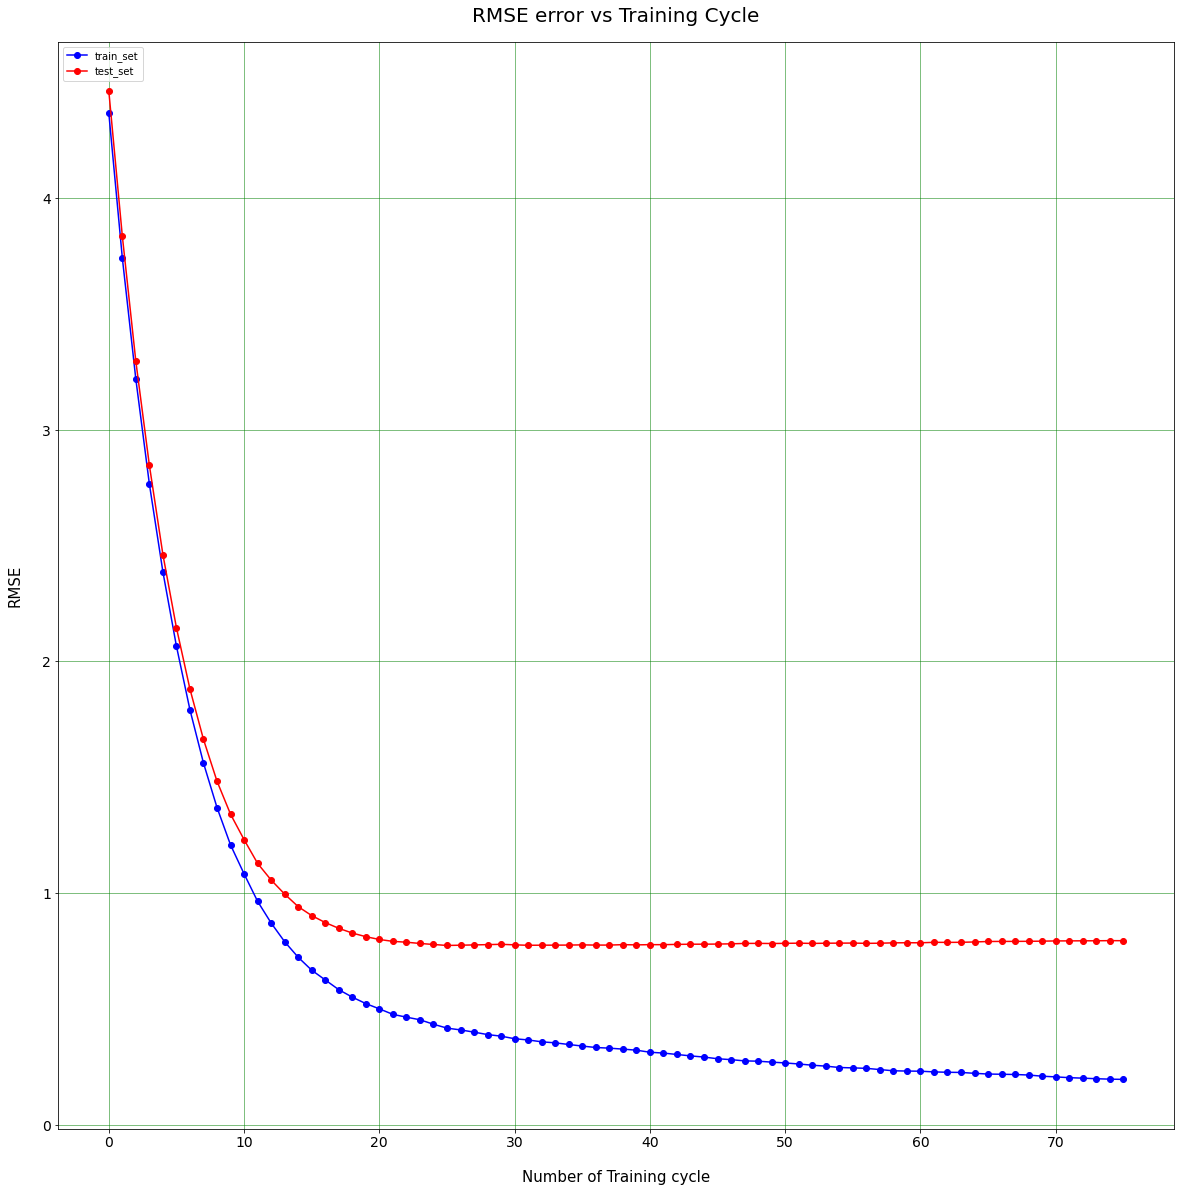

In [40]:
model_1_valid_rmse = models[1].evals_result()['validation_1']['rmse']
model_1_train_rmse = models[1].evals_result()['validation_0']['rmse']

import matplotlib.pyplot as plt

df = pd.DataFrame({'training cycle': range(0,76,1), 
                 'train_set':model_1_train_rmse,
                  'test_set':model_1_valid_rmse})

plt.figure(figsize=(20,20))

plt.plot( 'training cycle', 'train_set','bo-', data=df)
plt.plot( 'training cycle', 'test_set', 'ro-',data=df)


plt.title("RMSE error vs Training Cycle", fontsize =20, pad = 20)
plt.xlabel('Number of Training cycle',fontsize = 15, labelpad = 20)
plt.ylabel('RMSE', fontsize = 15, labelpad = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='upper left')
plt.grid(color='g', linestyle='-', linewidth=0.5)
plt.show()

## Testing
by Input your Location, time of the year and weather information here

In [18]:
# input the test information here!!
test_dict = {'LAT': 9 , 'LON': 7, 'YEAR':2019, 'MO': 7, 'DY':2,'RH2M': 50, 'PS': 100, 'T2M':23}

In [19]:
test_df = pd.DataFrame([test_dict])
test_df= test_df[['LAT', 'LON', 'YEAR', 'MO', 'DY', 'RH2M', 'PS', 'T2M']]
pred_df = sum([clf.predict(test_df) for clf in models])/5.0
pred_value = abs(pred_df[0])


In [20]:
print(f'The predicted All Sky Insolation on a horizontal surface for Your specified location is {pred_value:.4f} KWh per square meter per day')

The predicted All Sky Insolation on a horizontal surface for Your specified location is 5.7155 KWh per square meter per day


## Save the Model

In [24]:
import pickle
clf_no =0
for clf in models:
    pickle.dump(clf, open(f"XGBoost_KFold_model_{clf_no}.dat", "wb"))
    clf_no+=1